#### (01/11/2023) Initial experiments with compressing data using neural networks
Trying to train an autoencoder, normalizing the input data, training a network to output an image based on a much smaller input, e.g. an ID.

In [13]:
import torch
import torch.nn as nn 
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import numpy as np
import random as rd
import copy

In [16]:
batch_size = 100

# Import MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='../data', 
                                        train=True, 
                                    transform=transforms.ToTensor(),  
                                        download=True)
test_dataset = torchvision.datasets.MNIST(root='../data', 
                                        train=False, 
                                        transform=transforms.ToTensor()) 

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                        batch_size=batch_size, 
                                        shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                        batch_size=batch_size, 
                                        shuffle=False) 

In [21]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, activation_fnc):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.activation_fnc = activation_fnc
        self.l2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
         out = self.l1(x)
         out = self.activation_fnc(out)
         out = self.l2(out)
         # no activation and no softmax at the end
         return out

Training an autoencoder to compress an image

In [14]:
examples = iter(test_loader)
example_data, example_targets = examples.next()
example_targets = copy.deepcopy(example_data)

In [22]:
input_size = 784
output_size = 784 # 28x28
hidden_size = 500
activation_fnc = nn.ReLU()
num_classes = 10
num_epochs = 10
learning_rate = 0.001
device = 'cpu'
model = NeuralNet(input_size, hidden_size, output_size, activation_fnc).to(device)

In [18]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        if i != 0: # train only the first batch
            continue

        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        labels = images.reshape(-1, 28*28).to(device)

        # Forward pass
        outputs = model(labels)
        loss = criterion(outputs, images)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0 or i == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step[{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/10], Step[1/600], Loss: 0.1230
Epoch [2/10], Step[1/600], Loss: 0.1253
Epoch [3/10], Step[1/600], Loss: 0.1136
Epoch [4/10], Step[1/600], Loss: 0.1133
Epoch [5/10], Step[1/600], Loss: 0.1192
Epoch [6/10], Step[1/600], Loss: 0.1215
Epoch [7/10], Step[1/600], Loss: 0.1198
Epoch [8/10], Step[1/600], Loss: 0.1198
Epoch [9/10], Step[1/600], Loss: 0.1137
Epoch [10/10], Step[1/600], Loss: 0.1225


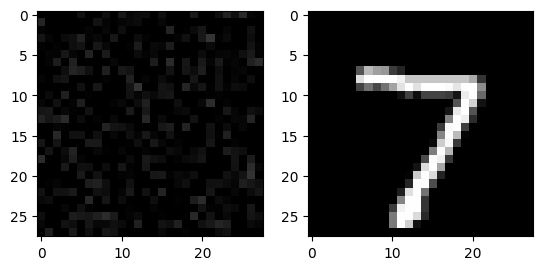

In [37]:
# testing the model
example_input = example_data[0]
example_input_reshaped = example_input.reshape(-1, 28*28).to(device)
with torch.no_grad():
    f, axarr = plt.subplots(1, 2)
    outputs = model(example_input_reshaped)
    axarr[0].imshow(outputs.reshape(28, 28).data.numpy(), cmap='gray', vmin=0, vmax=1)
    axarr[1].imshow(example_input.reshape(28, 28).data.numpy(), cmap='gray', vmin=0, vmax=1)    